# MVC project
- [GitHub](https://github.com/romainmartinez/mvc)

## Todo:
- test XGBoost
- add tests images
- article:
    - w/ 5 tests and this method: 93%
    - w/ 5 tests and old method: 85%
    - to get same metrics without prediction, need 12 tests

## 0. Setup

In [1]:
# Common imports
import pandas as pd
pd.set_option('display.float_format', '{:.5f}'.format)
import numpy as np
import os
import time

# the 'mvc' directory contains functions used but not necessary to understand the story
import mvc

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load data

In [2]:
df = pd.read_hdf('mvc.h5')
df.head()

,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,...,8,9,10,11,12,13,14,15,max,best_test
0,1,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10418,4
1,0,1,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13563,1
2,0,0,1,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.30076,2
3,0,0,0,1,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.26212,3
4,0,0,0,0,1,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.17047,2


### Drop tests
*see '`2_select_test.ipynb`' notebook*

In [3]:
# tests to drop according to previous analysis (2_select_test.ipynb)
to_keep = np.array(['4', '3', '2', '0', '5']).astype(int)
to_drop = np.delete(np.arange(16), to_keep)
df.drop(to_drop, axis=1, inplace=True)

### Normalization

In [4]:
# normalization with the fourth test
ref = 4
normalize = lambda x: x * 100 / x[ref]
# normalize = lambda x: x * 100 / x.max()

df.iloc[:, 13:-1] = df.iloc[:, 13:-1].apply(normalize, axis=1)

In [5]:
# remove muscles
# muscles_to_remove = ['supraspinatus', 'infraspinatus', 'subscapularis', 'pectoralis major'] # 8.73
# muscles_to_remove = ['supraspinatus', 'infraspinatus', 'subscapularis'] # 13.12
# muscles_to_remove = [] # 14.78
muscles_to_remove = ['pectoralis major'] # 10.50

index = []

for i in muscles_to_remove:
    idx = df[i] == 1
    index.extend(idx[idx].index)
df.drop(index, inplace=True, axis=0)

removed 69 rows


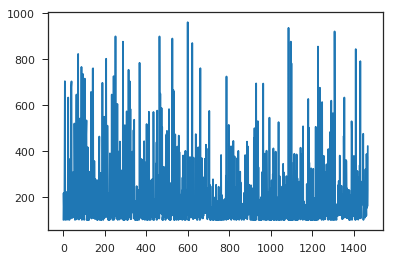

In [6]:
# remove outliers
threshold = 1000
rows_to_drop = (df['max'] == np.inf) | (df['max'] > threshold)
df.drop(rows_to_drop[rows_to_drop].index, inplace=True, axis=0)
print(f'removed {np.sum(rows_to_drop)} rows')
df['max'].plot()
plt.show()

## 2. Split the data

### Cross-Validation

In [7]:
from sklearn.model_selection import cross_val_score

### Stratified Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_labels = list(df.drop(['max', 'muscle', 'best_test'], axis=1).columns)
y_labels = ['max']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df[X_labels], df[y_labels], test_size=0.2, random_state=RANDOM_SEED,
                                       stratify=df['muscle'])

## 3. Select and Train Models

In [11]:
class TestandPlot:

    def __init__(self, models):
        self.models = models

    def test(self, X, y, display=True):
        names, means, stds, times = [[] for i in range(4)]

        for name, model in self.models.items():

            start = time.time()
            scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
            end = time.time()
            execution_time = end - start

            # we rectify the scores because cross_val_score expect a utility function (greater is better)
            # rather than a cost function (lower is better)
            scores_rectified = np.sqrt(-scores)

            means.append(scores_rectified.mean())
            stds.append(scores_rectified.std())
            times.append(execution_time)
            names.append(name)

            if display:
                print(name.upper())
                print(f'execution time: {execution_time:.3f} sec')
                print('-' * 10)

            self.df = pd.DataFrame({'mean': means, 'std': stds, 'time': times}, index=names).sort_values(by='mean')

    def plot(self, save_fig=False, title=None):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

        self.df['mean'].plot(kind='barh', ax=ax1, xerr=self.df['std'])
        ax1.set_xlabel('RMSE')
        ax1.set_title('Mean RMSE + STD')

        self.df['time'].plot(kind='barh', ax=ax2)
        ax2.set_xlabel('Time')
        ax2.set_title('Execution time')
        
        sns.despine(offset=10, trim=True)
        fig.tight_layout()

        plt.show()
        
        if save_fig:
            fig.savefig(f'./share/fig/{title}.pdf', transparent=True)

In [12]:
# linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
# trees
from sklearn.tree import DecisionTreeRegressor
# ensemble
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
# support vector
from sklearn.svm import SVR
# neighbors
from sklearn.neighbors import KNeighborsRegressor

In [13]:
models = {
    # linear models
    'lin_reg': LinearRegression(),
#     'sgd': SGDRegressor(random_state=RANDOM_SEED, max_iter=1000),
    'lasso': Lasso(random_state=RANDOM_SEED),
    'elasticnet': ElasticNet(random_state=RANDOM_SEED),
    'ridge': Ridge(random_state=RANDOM_SEED),
    # trees
    'dtr': DecisionTreeRegressor(random_state=RANDOM_SEED),
    # ensemble
    'adaboost': AdaBoostRegressor(random_state=RANDOM_SEED),
    'bagging': BaggingRegressor(random_state=RANDOM_SEED),
    'randforest': RandomForestRegressor(random_state=RANDOM_SEED),
    'extratree': ExtraTreesRegressor(random_state=RANDOM_SEED),
    'gradientboosting': GradientBoostingRegressor(),
    # support vector
    'svr': SVR(kernel='linear'),
    'Kneighbors': KNeighborsRegressor()
}

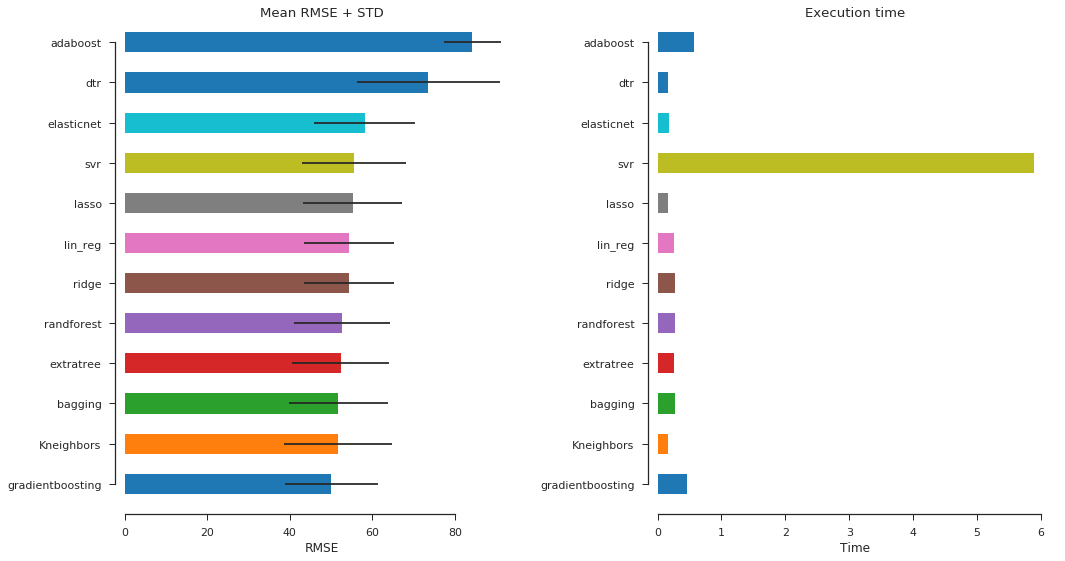

In [14]:
model_test = TestandPlot(models)
model_test.test(X_train, np.ravel(y_train), display=False)
model_test.plot()

#### Outcomes
- Ensemble methods looks very promising
- top 3: _Extra Tree Regressor_, _Gradient Boosting_ and _Random Forest_
- Stochastic Gradient Descent is the slowest, because the features are not scaled

## 4. Fine-tune the model (_Extra Tree Regressor_, _Gradient Boosting_ and _Random Forest_)

### Randomized Grid Search

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [16]:
# param_distrib = {}

# # extra tree
# param_distrib['extratree'] = {
#     'n_estimators': randint(low=1, high=200),
#     'criterion': ['mse', 'mae'],
#     'max_features': randint(low=10, high=18),
#     'bootstrap': [True, False]
# }

# # gradient boosting
# param_distrib['gradientboosting'] = {
#     'loss': ['ls', 'lad', 'huber', 'quantile'],
#     'learning_rate': uniform(0.003, 0.4),
#     'n_estimators': randint(low=50, high=300)
# }

# # random forest
# param_distrib['randforest'] = {
#     'n_estimators': randint(low=50, high=300),
#     'criterion': ['mse', 'mae'],
#     'max_features': randint(low=10, high=18),
#     'bootstrap': [True, False]
# }

In [17]:
# n_iter = 1000

# random_search_model = {
#     'extratree': ExtraTreesRegressor(random_state=RANDOM_SEED),
#     'gradientboosting': GradientBoostingRegressor(),
#     'randforest': RandomForestRegressor(random_state=RANDOM_SEED)
# }

# random_search = {}

# for key, params in param_distrib.items():
#     print(f'optimize {key.upper()} hyperparameters...')
#     start = time.time()
#     random_search[key] = RandomizedSearchCV(random_search_model[key], param_distributions=params,
#                                             n_iter=n_iter, cv=5, random_state=RANDOM_SEED,
#                                             scoring='neg_mean_squared_error', n_jobs=-1)
    
#     random_search[key].fit(X_train, np.ravel(y_train))
    
#     end = time.time()
    
#     print(f'best params: {random_search[key].best_params_}')
#     print(f'execution time: {end - start:.3f} sec [{n_iter} iterations]')
    
#     print('-' * 10)

In [18]:
try:
    optimized_params = {
        'extratree': random_search['extratree'].best_params_,
        'gradientboosting': random_search['gradientboosting'].best_params_,
        'randforest': random_search['randforest'].best_params_,
    }
except NameError:
    optimized_params = {
        'extratree': {'bootstrap': False, 'criterion': 'mse', 'max_features': 14, 'n_estimators': 45},
        'gradientboosting': {'learning_rate': 0.27639418010407163, 'loss': 'huber', 'n_estimators': 115},
        'randforest': {'bootstrap': True, 'criterion': 'mse', 'max_features': 14, 'n_estimators': 260},
    }

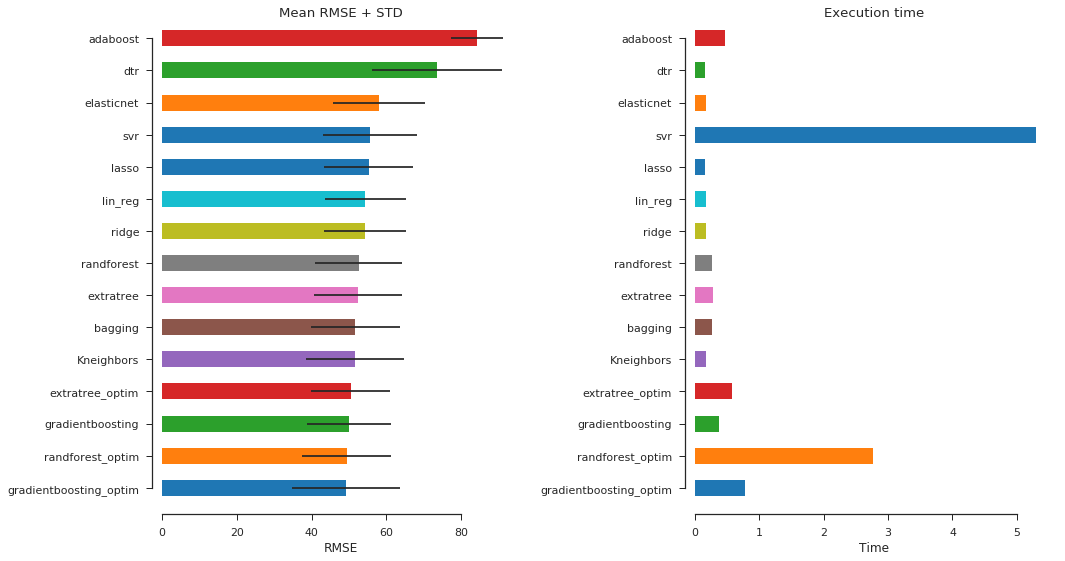

In [19]:
# re-test optimized models with custom functions
optimized_models = {
    'extratree_optim': ExtraTreesRegressor(random_state=RANDOM_SEED, **optimized_params['extratree']),
    'gradientboosting_optim': GradientBoostingRegressor(**optimized_params['gradientboosting']),
    'randforest_optim': RandomForestRegressor(random_state=RANDOM_SEED, **optimized_params['randforest']),
}

models.update(optimized_models)

optimized_model_test = TestandPlot(models)
optimized_model_test.test(X_train, np.ravel(y_train), display=False)
optimized_model_test.plot(save_fig=True, title='models')

## 5. Final predictions

- We select our best model (`extratree_optim`) for our final evaluation

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
import spm1d

In [21]:
class Evaluate:
    def __init__(self, model):
        self.model = model
        
    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test, y_test):        
        self.predictions = self.model.predict(X_test)
        self.scores = {
            'rmse': np.sqrt(mean_squared_error(y_test, self.predictions)),
            'r2': r2_score(y_test, self.predictions)
        }
        
        print(f'final RMSE: {self.scores["rmse"]}')
        print(f'final R2: {self.scores["r2"]}')
        
    def to_dataframe(self, y_test, muscles):
        return pd.DataFrame({'predictions': self.predictions, 'labels': y_test.iloc[:, 0], 'muscles': muscles})
    
    def plot(self, df, save_fig=False, title=None):
        fig, ax = plt.subplots(figsize=(11, 8.5))

        # labels vs. predictions
        groups = df.groupby('muscles')
        for muscle, values in groups:
            ax.scatter(values['labels'], values['predictions'],
                       s=200, marker='o', alpha=.8, label=muscle)
        
        # base line
        baseline = (0, 1)
        ax.plot(baseline, 'k--', label='perfect prediction')
        
#         ax.xaxis.set_ticks(np.linspace(0, 1, num=5))
#         ax.yaxis.set_ticks(np.linspace(0, 1, num=5))
        ax.axis('equal')
        
        ax.legend(loc='lower right')
        plt.title(f'RMSE = {self.scores["rmse"]:.3f}\nR2 = {self.scores["r2"]:.3f}')
        plt.xlabel('Labels')
        plt.ylabel('Predictions')

        sns.despine(offset=10, trim=True)
        fig.tight_layout()
        plt.show()
        
        if save_fig:
            fig.savefig(f'./share/fig/{title}.pdf', transparent=True)
        
    def t_test(self, df, alpha, iterations):
        rmses, r2s, p, names, h0reject = [[] for i in range(5)]
        for idx, muscle in enumerate(df['muscles'].unique()):
            yA = df[df['muscles'] == muscle]['labels']
            yB = df[df['muscles'] == muscle]['predictions']

            t_spm = spm1d.stats.nonparam.ttest2(yA, yB)
            t_spmi = t_spm.inference(alpha, two_tailed=True, iterations=iterations, force_iterations=True)
            
            rmse = np.sqrt(mean_squared_error(yA, yB))
            r2 = r2_score(yA, yB)
            
            scores = f'RMSE = {rmse:.3f}\nR2 = {r2:.3f}'
            
            title = print(f't-test {muscle.upper()}\n' + self.display_results(t_spmi) + '\n' + scores)
                
            rmses.append(rmse)
            r2s.append(r2)
            p.append(t_spmi.p)
            h0reject.append(t_spmi.h0reject)
            names.append(muscle)
            
            print('-' * 10)
            
        return pd.DataFrame({'rmse': rmses, 'r2': r2s, 'p': p, 'h0reject': h0reject}, index=names).sort_values(by='r2')
     
    @staticmethod
    def display_results(spm):
        if spm.h0reject:
            output = f'null hypothesis rejected, T2={spm.z:.3f}, p={spm.p:.5f}'
        else:
            output = f'null hypothesis not rejected (p={spm.p:.5f})'
        return output

In [22]:
selected_model = models['extratree_optim']
final = Evaluate(selected_model)
final.fit(X_train, np.ravel(y_train))
final.predict(X_test, y_test)

final RMSE: 44.20728592889829
final R2: 0.9039566203388044


In [23]:
# one-hot encoding muscle feature to plain
MUSCLES_COLUMNS = list(X_test.columns[:12])
muscles = X_test[MUSCLES_COLUMNS].idxmax(1)

final_df = final.to_dataframe(y_test, muscles)

In [24]:
final_df.head()

,labels,muscles,predictions
683,132.46032,middle deltoid,130.73081
1064,158.48824,supraspinatus,161.75325
242,725.25924,latissimus dorsi,728.17329
359,136.67186,lower trapezius,117.29442
587,115.67590,middle deltoid,116.82783


In [59]:
total_mean = []
percentage = []
yerr = []
temp = {}
error = {}

d = {}

for muscle in set(final_df['muscles']):
    labels = final_df[final_df['muscles'] == muscle]['labels']
    predictions = final_df[final_df['muscles'] == muscle]['predictions']
    
    temp[muscle] = np.abs(predictions - labels)/labels*100
    
    t = 0
    for err in np.linspace(10, 100, 9):
        if not muscle in error:
            error[muscle] = [sum(temp[muscle] < err) / temp[muscle].shape[0] * 100]
        else:
            error[muscle].append(sum(temp[muscle] < err) / temp[muscle].shape[0] * 100 - sum(error[muscle]))
        t += 1
    
    moy = np.mean(np.abs(predictions - labels)/labels*100)
    std = np.std(np.abs(predictions - labels)/labels*100)
    percentage.append(moy)
    yerr.append(std)
    print(f'{muscle}: {moy:.1f}')
    print(f'\tstd: {std:.1f}')
    total_mean.append(moy)
    
    
print(f'\nglobal mean: {np.mean(total_mean)}')

supraspinatus: 5.3
	std: 4.1
infraspinatus: 18.7
	std: 15.2
lower trapezius: 9.6
	std: 12.5
middle trapezius: 6.9
	std: 5.1
subscapularis: 20.7
	std: 18.0
posterior deltoid: 5.7
	std: 6.0
serratus anterior: 10.6
	std: 9.4
anterior deltoid: 12.6
	std: 10.0
upper trapezius: 5.5
	std: 9.7
middle deltoid: 7.0
	std: 7.0
latissimus dorsi: 12.7
	std: 12.6

global mean: 10.50460646984764


In [60]:
percentage

[5.3169172020237641,
 18.744253636205965,
 9.6441915577130732,
 6.9207047786680791,
 20.725168333313487,
 5.6839258572618139,
 10.590144543324659,
 12.641749824111443,
 5.5080212103190531,
 7.0458725555163086,
 12.729721669866391]

In [61]:
percentage = pd.DataFrame({
    'error': percentage,
    'std': yerr}, index=set(final_df['muscles']))

In [62]:
percentage

,error,std
supraspinatus,5.31692,4.07600
infraspinatus,18.74425,15.16131
lower trapezius,9.64419,12.53022
middle trapezius,6.92070,5.05650
subscapularis,20.72517,17.97377
posterior deltoid,5.68393,5.97182
serratus anterior,10.59014,9.43027
anterior deltoid,12.64175,10.03800
upper trapezius,5.50802,9.68661
middle deltoid,7.04587,7.04029


In [26]:
bar = []
name = []
for key, value in error.items():
    bar.append(error[key])
    name.append(key)
bar = pd.DataFrame(bar, index=name)

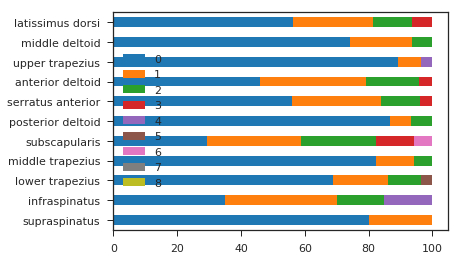

In [27]:
bar.plot(kind='barh', stacked=True)
plt.show()

In [28]:
alpha = 0.05
iterations = 10000
scores = final.t_test(df=final_df, alpha=alpha, iterations=iterations)

t-test MIDDLE DELTOID
null hypothesis not rejected (p=0.70120)
RMSE = 15.197
R2 = 0.610
----------
t-test SUPRASPINATUS
null hypothesis not rejected (p=0.42260)
RMSE = 7.855
R2 = 0.835
----------
t-test LATISSIMUS DORSI
null hypothesis not rejected (p=0.86360)
RMSE = 69.044
R2 = 0.898
----------
t-test LOWER TRAPEZIUS
null hypothesis not rejected (p=0.71680)
RMSE = 50.345
R2 = 0.863
----------
t-test UPPER TRAPEZIUS
null hypothesis not rejected (p=0.72260)
RMSE = 23.804
R2 = 0.717
----------
t-test SUBSCAPULARIS
null hypothesis not rejected (p=0.78980)
RMSE = 92.178
R2 = 0.704
----------
t-test INFRASPINATUS
null hypothesis not rejected (p=0.75880)
RMSE = 79.368
R2 = 0.784
----------
t-test SERRATUS ANTERIOR
null hypothesis not rejected (p=0.87820)
RMSE = 26.487
R2 = 0.787
----------
t-test POSTERIOR DELTOID
null hypothesis not rejected (p=0.98340)
RMSE = 22.675
R2 = 0.947
----------
t-test MIDDLE TRAPEZIUS
null hypothesis not rejected (p=0.76240)
RMSE = 12.178
R2 = 0.940
----------
t-

In [68]:
scores = scores.join(percentage)

In [33]:
scores

,h0reject,p,r2,rmse
anterior deltoid,False,0.92060,0.56976,30.48041
middle deltoid,False,0.70120,0.61027,15.19689
subscapularis,False,0.78980,0.70401,92.17765
upper trapezius,False,0.72260,0.71702,23.80431
infraspinatus,False,0.75880,0.78352,79.36848
serratus anterior,False,0.87820,0.78731,26.48713
supraspinatus,False,0.42260,0.83535,7.85507
lower trapezius,False,0.71680,0.86254,50.34494
latissimus dorsi,False,0.86360,0.89839,69.04418
middle trapezius,False,0.76240,0.94027,12.17801


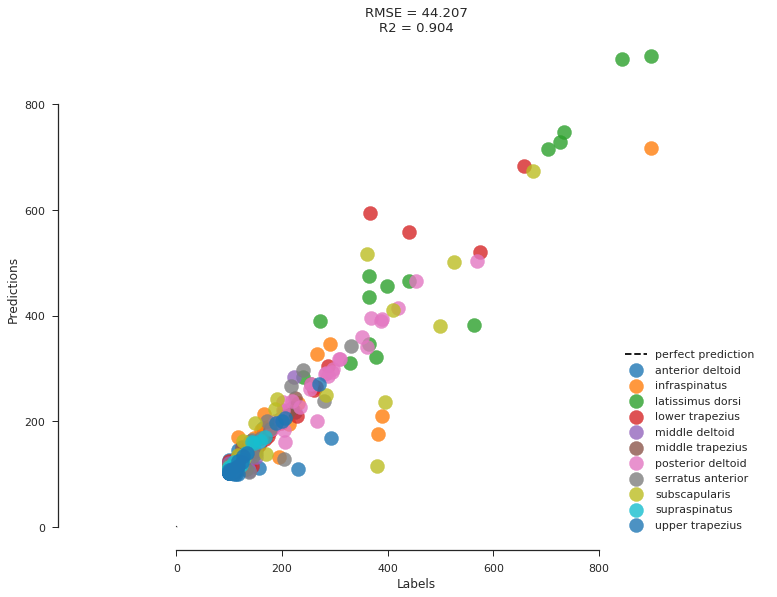

In [30]:
# plot
final.plot(final_df, save_fig=True, title='labels_vs_predictions_all')

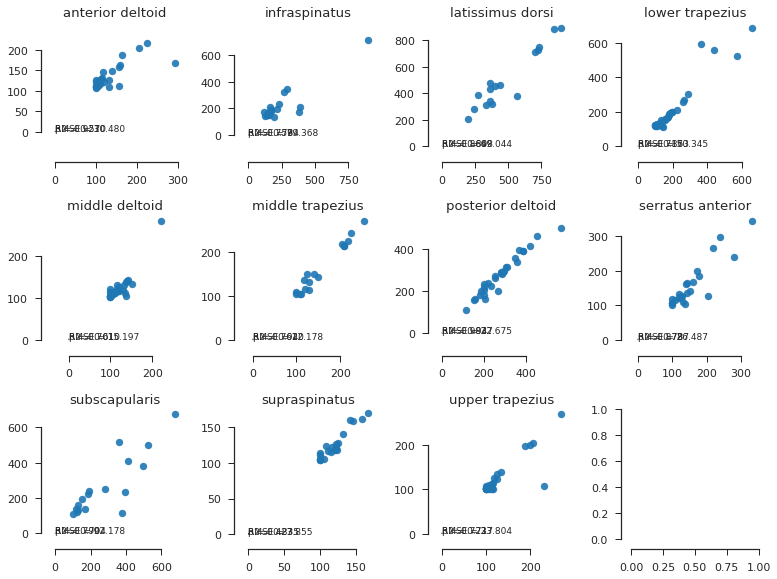

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(11, 8.25))
# labels vs. predictions
groups = final_df.groupby('muscles')
for (muscle, values), ax in zip(groups, axes.ravel()):
    ax.scatter(values['labels'], values['predictions'],
               s=50, marker='o', alpha=.9, label=muscle)
    # base line
    baseline = (0, 1)
    ax.plot(baseline, 'k--', label='perfect prediction')
    
#     ax.xaxis.set_ticks(np.linspace(0, 1, num=5))
#     ax.yaxis.set_ticks(np.linspace(0, 1, num=5))
    ax.axis('equal')
    
    ax.set_title(muscle)
    
    ax.text(0, .9, f'RMSE = {scores["rmse"][muscle]:.3f}', fontsize=9)
    ax.text(0, .8, f'R2 = {scores["r2"][muscle]:.3f}', fontsize=9)
    ax.text(0, .7, f'p = {scores["p"][muscle]:.3f}', fontsize=9)

sns.despine(offset=10, trim=True)
fig.tight_layout()
plt.show()

fig.savefig(f'./share/fig/labels_vs_predictions.pdf', transparent=True)

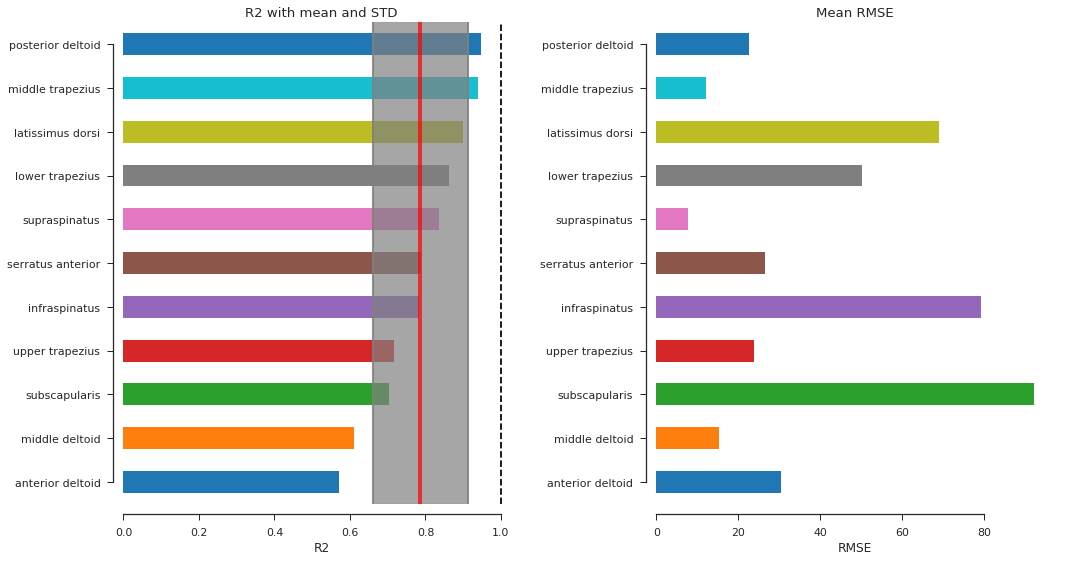

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

scores['r2'].plot(kind='barh', ax=ax1)

ax1.axvline(x=1, linestyle='--', color='k') # perfect prediction
final_mean = scores['r2'].mean()
final_std = scores['r2'].std()
ax1.axvline(x=final_mean, linewidth=4, color='red', alpha=0.7) # mean
ax1.axvline(x=final_mean + final_std, color='gray') # mean + std
ax1.axvline(x=final_mean - final_std, color='gray') # mean - std
ax1.axvspan(final_mean - final_std, final_mean + final_std, alpha=0.7, color='gray')

ax1.set_xlabel('R2')
ax1.set_title('R2 with mean and STD')

scores['rmse'].plot(kind='barh', ax=ax2)
ax2.set_xlabel('RMSE')
ax2.set_title('Mean RMSE')

sns.despine(offset=10, trim=True)
fig.tight_layout()

plt.show()

fig.savefig(f'./share/fig/rmse_r2_by_muscle.pdf', transparent=True)

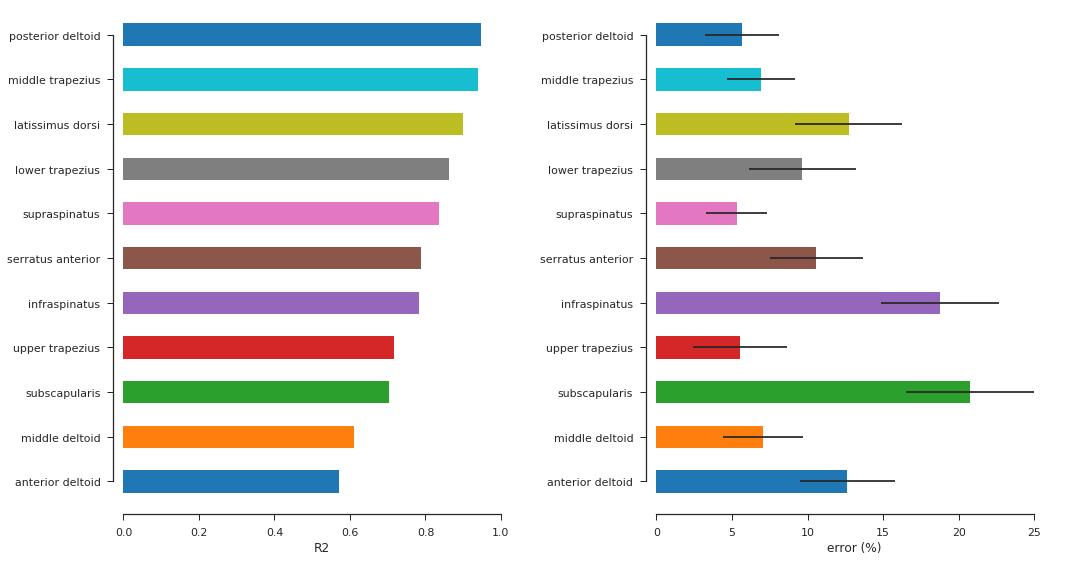

In [78]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

scores['r2'].plot(kind='barh', ax=ax1)

ax1.axvline(x=1, linestyle='--', color='white') # perfect prediction

ax1.set_xlabel('R2')
# ax1.set_title('R2 with mean and STD')

scores['error'].plot(kind='barh', ax=ax2, xerr=np.sqrt(scores['std']))
ax2.set_xlabel('error (%)')
# ax2.set_title('error (%)')

sns.despine(offset=10, trim=True)
fig.tight_layout()

plt.show()

fig.savefig(f'./share/fig/rmse_r2_by_muscle.pdf', transparent=True)

In [34]:
muscle

'upper trapezius'